## Import

In [1]:
from mlprimitives.custom.timeseries_preprocessing import time_segments_aggregate
from mlprimitives.custom.timeseries_preprocessing import rolling_window_sequences
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from notebooks.tulog.model import hyperparameters
from orion.primitives.tadgan import TadGAN
from orion.data import load_signal, load_anomalies
from orion import Orion
from notebooks.tulog.utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

import matplotlib.pyplot as plt
import numpy as np
import warnings
import os

warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


## Load data

In [2]:
signal = 'nyc_taxi'
df = load_signal(signal)
known_anomalies = load_anomalies(signal)

In [3]:
df.head(5)

,timestamp,value
0,1404165600,10844.0
1,1404167400,8127.0
2,1404169200,6210.0
3,1404171000,4656.0
4,1404172800,3820.0


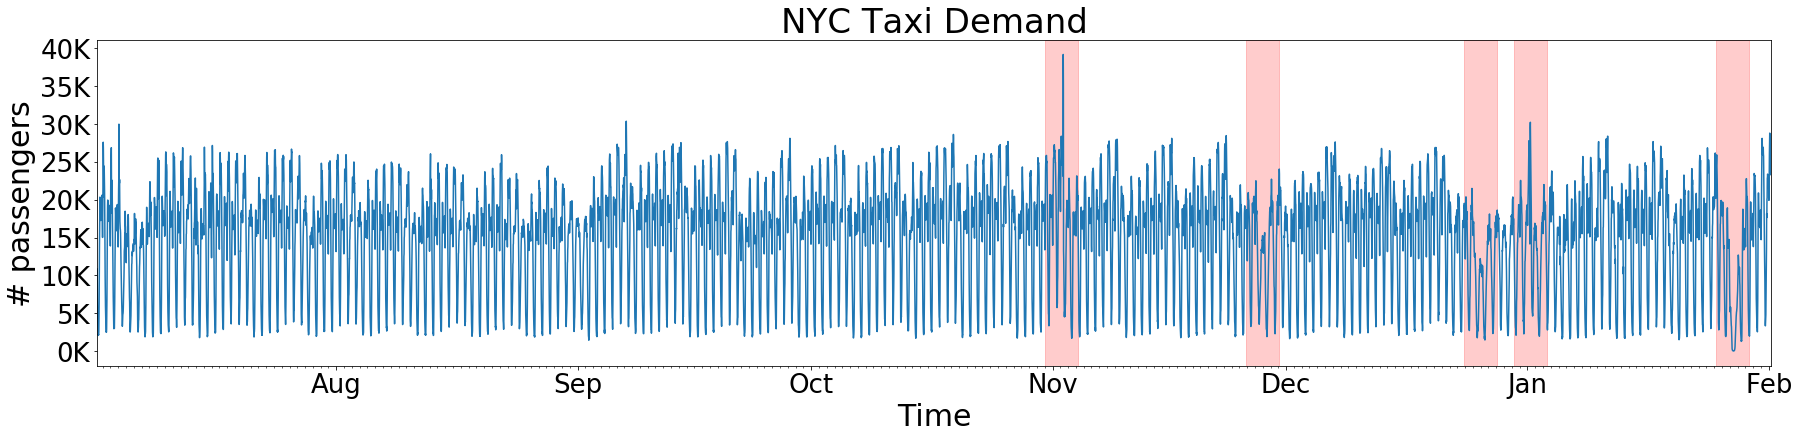

In [4]:
plot(df, known_anomalies)

## Modeling

* using json file

In [8]:
json_path = './orion/pipelines/verified/tadgan/'

In [14]:
orion = Orion(pipeline=json_path+'tadgan.json')

In [15]:
# fit the pipeline on the data then detect anomalies
anomalies = orion.fit_detect(df)

Epoch: 1/35, [Dx loss: [ 6.006809   -0.2995578   0.01954431  0.6286822 ]] [Dz loss: [1.9510142  0.2930374  0.04177501 0.1616202 ]] [G loss: [ 2.093956   -0.03933236 -0.04946125  0.21827497]]
Epoch: 2/35, [Dx loss: [-1.1182228  -3.540804    0.29373205  0.2128849 ]] [Dz loss: [ 0.8456212  -0.0443722   0.5126852   0.03773082]] [G loss: [ 1.2369175  -0.33971623 -0.5709162   0.214755  ]]
Epoch: 3/35, [Dx loss: [-2.9892242  -3.8652642   0.49305335  0.03829864]] [Dz loss: [ 1.5902836  -0.36244613  1.6880461   0.02646837]] [G loss: [ 0.16641432 -0.49649334 -1.4677782   0.21306857]]
Epoch: 4/35, [Dx loss: [-3.3131404  -4.972349    0.9407463   0.07184628]] [Dz loss: [ 2.4527647  -0.81796646  2.8654518   0.04052788]] [G loss: [-0.606882   -0.7682077  -2.3282704   0.24895962]]
Epoch: 5/35, [Dx loss: [-3.4889145  -4.6241183   0.6682603   0.04669441]] [Dz loss: [ 2.4266841  -1.1959401   2.8021924   0.08204315]] [G loss: [ 1.3039511  -0.69936347 -1.0161146   0.3019429 ]]
Epoch: 6/35, [Dx loss: [-3.80

In [16]:
anomalies.head(5)

,start,end,severity
0,1418529600,1420711200,0.100168


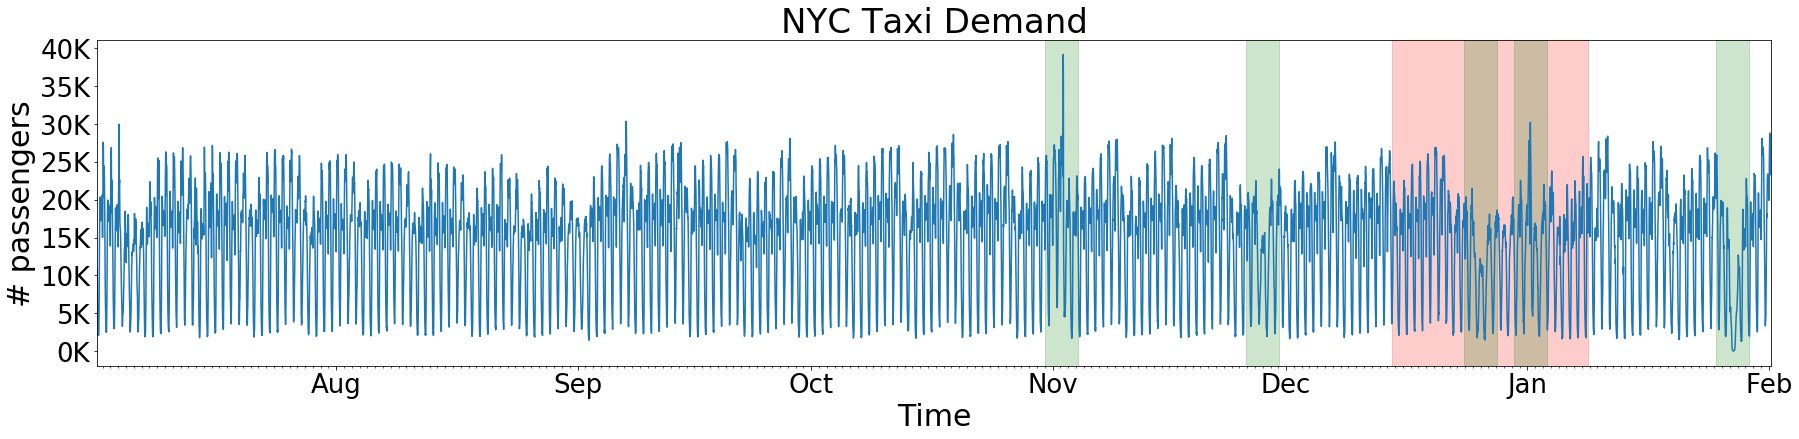

In [25]:
plot(df, [anomalies, known_anomalies])

* data preprocessing

In [5]:
# equalize steps (decide on a frequency)
X, index = time_segments_aggregate(df, 
                                   interval=1800, 
                                   time_column='timestamp',  
                                   method=['mean'])

# impute missing values
imp = SimpleImputer()
X = imp.fit_transform(X)

# scale the data between [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

* modeling

In [6]:
X, X_index, y, y_index = rolling_window_sequences(X, index, window_size=100, target_size=1, step_size=1,target_column=0)

print("Training data input shape: {}".format(X.shape))

Training data input shape: (10222, 100, 1)


In [7]:
hyperparameters["epochs"] = 100
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch: 1/100, [Dx loss: [-0.60295403 -3.0713167   1.6284759   0.0839886 ]] [Dz loss: [-1.2381959  -1.0158697  -1.6074198   0.13850947]] [G loss: [ 2.6127563 -1.6149186  2.7015054  0.1526169]]
Epoch: 2/100, [Dx loss: [-0.83006227 -4.4980135   3.5157285   0.0152224 ]] [Dz loss: [-2.9553914 -1.3956124 -2.8890908  0.1329311]] [G loss: [ 1.5777005  -3.4366436   3.716375    0.12979689]]
Epoch: 3/100, [Dx loss: [-0.49658966 -7.290282    6.6421876   0.01515021]] [Dz loss: [-1.028762   -0.991713   -0.52725554  0.0490207 ]] [G loss: [-4.7527013  -6.6128216   0.7642762   0.10958438]]
Epoch: 4/100, [Dx loss: [-0.36257523 -7.671046    7.1190467   0.0189431 ]] [Dz loss: [-0.8731413  -0.5940286  -0.68251705  0.04034044]] [G loss: [-4.4985943  -6.6008797   0.923383    0.11789031]]
Epoch: 5/100, [Dx loss: [-0.44696394  4.607909  

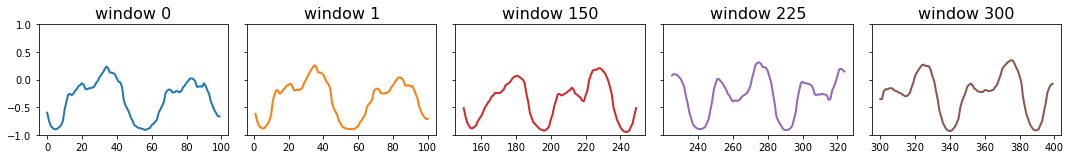

In [8]:
# reconstruct
X_hat, critic = tgan.predict(X)

# visualize X_hat
plot_rws(X_hat)

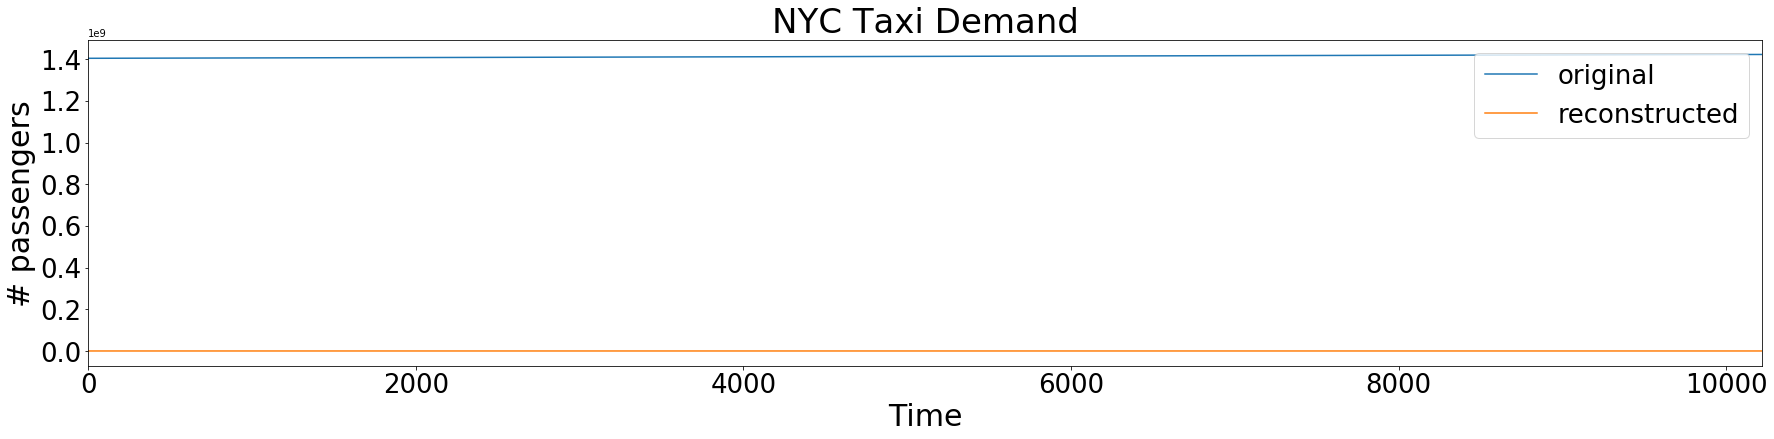

In [9]:
# flatten the predicted windows
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

* post-preprocessing

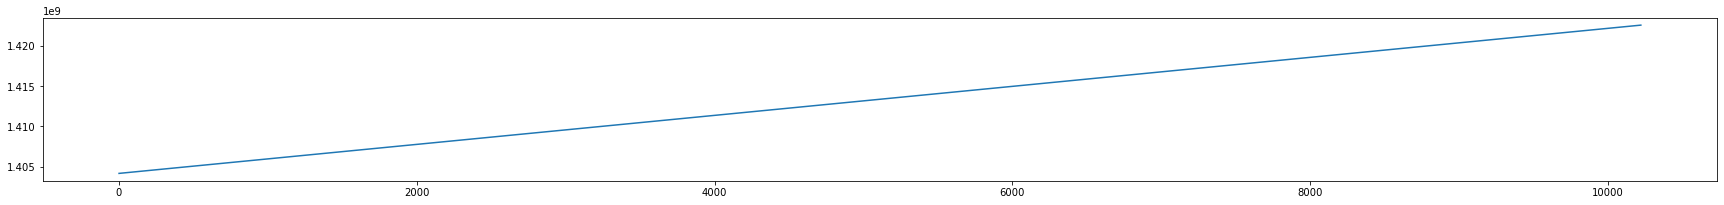

In [10]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

* raw

In [11]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp')

* imputation

In [12]:
imp = SimpleImputer()
X = imp.fit_transform(X)

* scaling

In [13]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [14]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

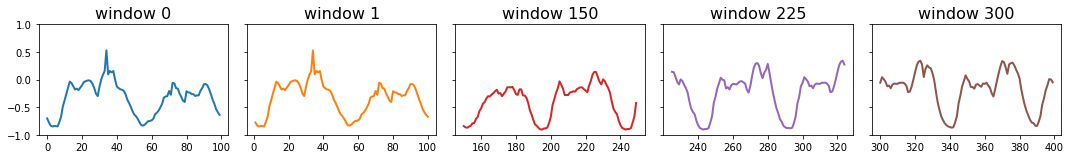

In [15]:
plot_rws(X)

* modeling

In [16]:
hyperparameters["epochs"] = 100
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

Epoch: 1/100, [Dx loss: [-0.8196679  -3.068404    1.6023266   0.06464107]] [Dz loss: [-0.58935446 -1.5435302  -0.26585093  0.12200265]] [G loss: [ 0.914809   -1.620961    0.82192343  0.17138469]]
Epoch: 2/100, [Dx loss: [-0.73221725 -3.864442    2.948512    0.01837142]] [Dz loss: [-2.3947794  -1.0804576  -2.2846239   0.09703021]] [G loss: [ 1.2648188  -2.8231807   2.9479227   0.11400762]]
Epoch: 3/100, [Dx loss: [-0.5709559  -2.6726809   1.9607725   0.01409542]] [Dz loss: [-1.203647   -0.3462318  -1.3181366   0.04607211]] [G loss: [ 0.75188816 -1.8112036   1.8552133   0.07078786]]
Epoch: 4/100, [Dx loss: [-0.53489035 -8.710001    8.062371    0.01127407]] [Dz loss: [-1.2728035   0.4287315  -2.372567    0.06710308]] [G loss: [-4.417285   -8.130796    3.0067625   0.07067488]]
Epoch: 5/100, [Dx loss: [-0.4972766   1.6625493  -2.2983134   0.01384879]] [Dz loss: [-0.98502463  0.6019408  -2.10668     0.05197141]] [G loss: [5.6837206 2.530551  2.5542693 0.05989  ]]
Epoch: 6/100, [Dx loss: [-0.

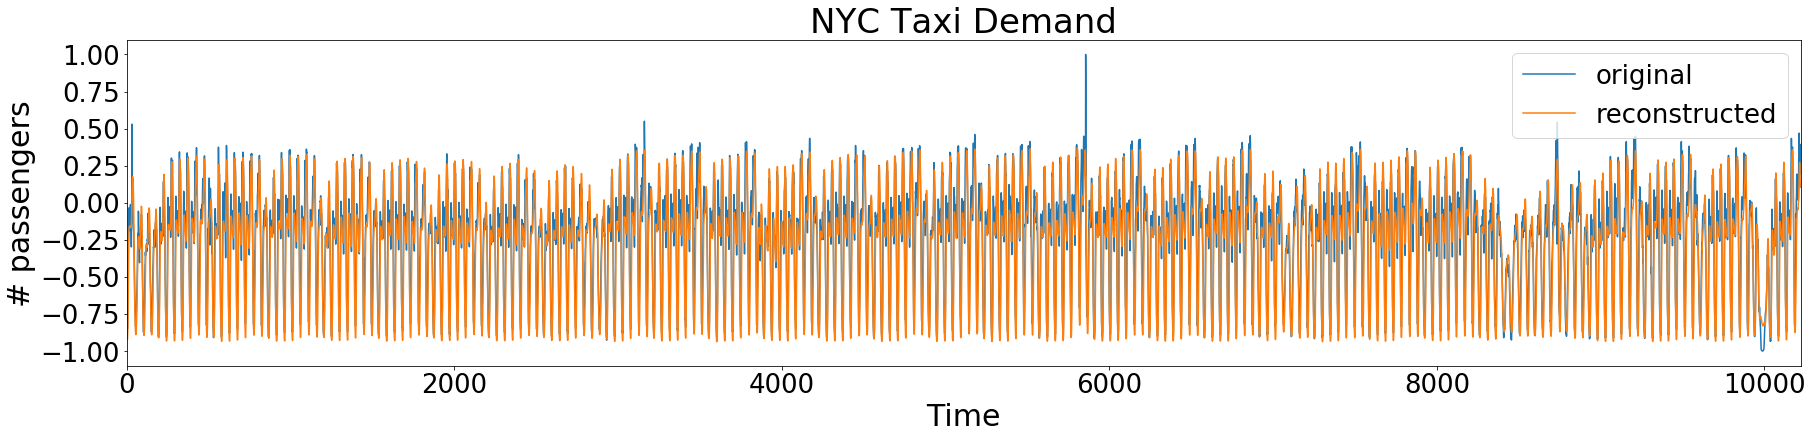

In [17]:
# flatten the predicted windows
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

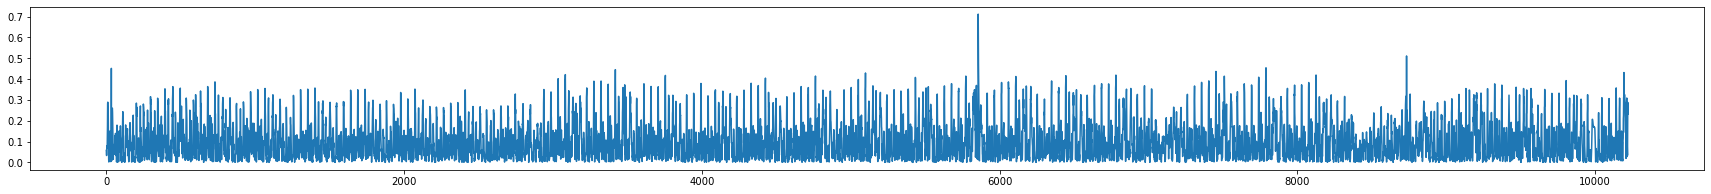

In [18]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

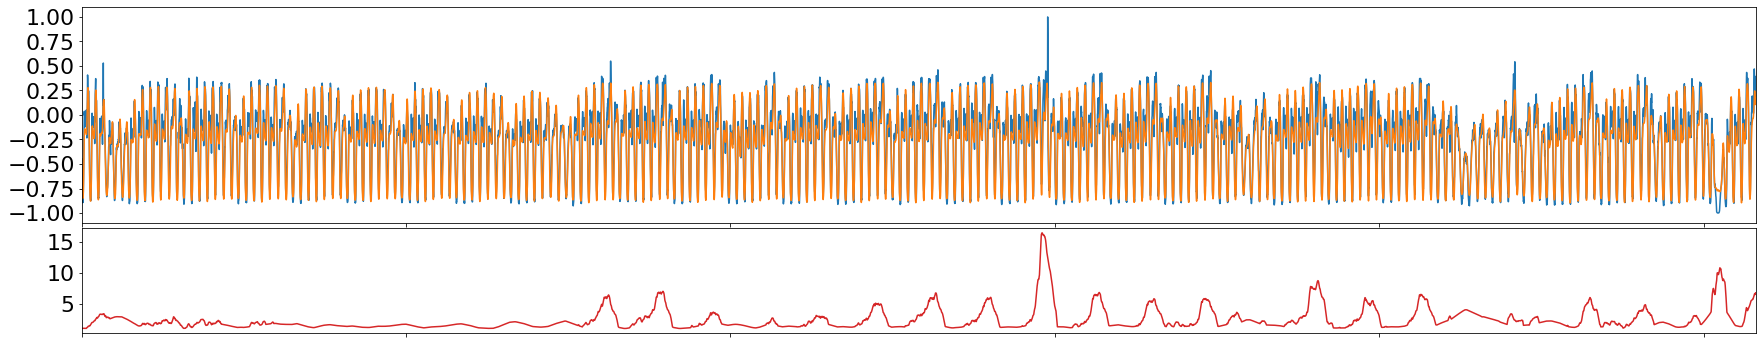

In [20]:
from orion.primitives.tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

In [21]:
# threshold
thresh = 10

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

[(1414796400, 1414918800, 13.810152934475148),
 (1422316800, 1422320400, 10.007743732630095),
 (1422336600, 1422361800, 10.502358286871429)]

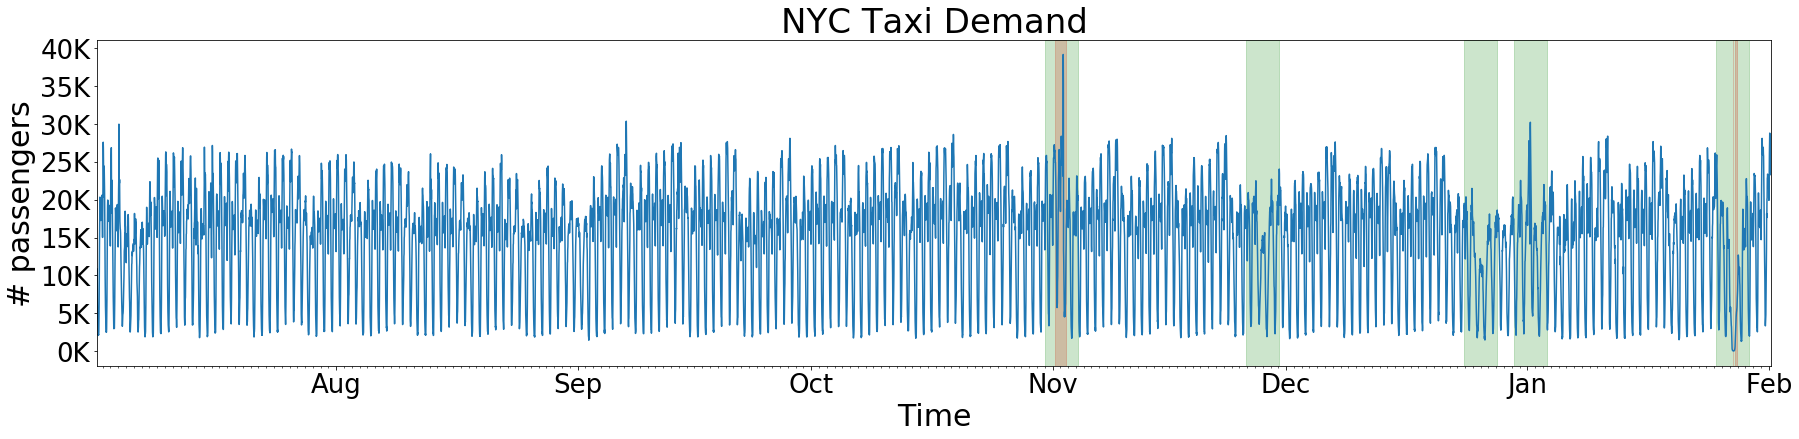

In [23]:
import pandas as pd
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

## anomal gap maximize tadgan

In [19]:
def pg_loss(y_true, y_pred) :
    global ridge_value, baseline_ridge, ridge_value_baseline
    
    policy_gradient_cce = -tf.math.log(y_pred + 1e-6)
    ridge_advantage = tf.stop_gradient(baseline_ridge-ridge_value)
    ridge_maximize_loss = tf.reduce_mean(policy_gradient_cce * tf.cast(ridge_advantage, dtype = tf.float32))
    
    return ridge_maximize_loss

In [ ]:
class TadGAN(object):

    def __getstate__(self):
        networks = ['critic_x', 'critic_z', 'encoder', 'generator']
        modules = ['optimizer', 'critic_x_model', 'critic_z_model', 'encoder_generator_model']

        state = self.__dict__.copy()

        for module in modules:
            del state[module]

        for network in networks:
            with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=False) as fd:
                keras.models.save_model(state.pop(network), fd.name, overwrite=True)

                state[network + '_str'] = fd.read()

        return state

    def __setstate__(self, state):
        networks = ['critic_x', 'critic_z', 'encoder', 'generator']
        for network in networks:
            with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=False) as fd:
                fd.write(state.pop(network + '_str'))
                fd.flush()

                state[network] = keras.models.load_model(fd.name)

        self.__dict__ = state

    def _build_model(self, hyperparameters, layers, input_shape):
        x = Input(shape=input_shape)
        model = keras.models.Sequential()

        for layer in layers:
            built_layer = build_layer(layer, hyperparameters)
            model.add(built_layer)

        return Model(x, model(x))

    def _wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def _gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        gradients = K.gradients(y_pred, averaged_samples)[0]
        gradients_sqr = K.square(gradients)
        gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        gradient_penalty = K.square(1 - gradient_l2_norm)
        return K.mean(gradient_penalty)

    def __init__(self, shape, encoder_input_shape, generator_input_shape, critic_x_input_shape,
                 critic_z_input_shape, layers_encoder, layers_generator, layers_critic_x,
                 layers_critic_z, optimizer, learning_rate=0.0005, epochs=2000, latent_dim=20,
                 batch_size=64, iterations_critic=5, **hyperparameters):

        self.shape = shape
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.iterations_critic = iterations_critic
        self.epochs = epochs
        self.hyperparameters = hyperparameters

        self.encoder_input_shape = encoder_input_shape
        self.generator_input_shape = generator_input_shape
        self.critic_x_input_shape = critic_x_input_shape
        self.critic_z_input_shape = critic_z_input_shape

        self.layers_encoder, self.layers_generator = layers_encoder, layers_generator
        self.layers_critic_x, self.layers_critic_z = layers_critic_x, layers_critic_z

        self.optimizer = import_object(optimizer)(learning_rate)

    def _build_tadgan(self, **kwargs):

        hyperparameters = self.hyperparameters.copy()
        hyperparameters.update(kwargs)

        self.encoder = self._build_model(hyperparameters, self.layers_encoder,
                                         self.encoder_input_shape)
        self.generator = self._build_model(hyperparameters, self.layers_generator,
                                           self.generator_input_shape)
        self.critic_x = self._build_model(hyperparameters, self.layers_critic_x,
                                          self.critic_x_input_shape)
        self.critic_z = self._build_model(hyperparameters, self.layers_critic_z,
                                          self.critic_z_input_shape)

        self.generator.trainable = False
        self.encoder.trainable = False

        z = Input(shape=(self.latent_dim, 1))
        x = Input(shape=self.shape)
        x_ = self.generator(z)
        z_ = self.encoder(x)
        fake_x = self.critic_x(x_)
        valid_x = self.critic_x(x)
        interpolated_x = RandomWeightedAverage()([x, x_])
        validity_interpolated_x = self.critic_x(interpolated_x)
        partial_gp_loss_x = partial(self._gradient_penalty_loss, averaged_samples=interpolated_x)
        partial_gp_loss_x.__name__ = 'gradient_penalty'
        self.critic_x_model = Model(inputs=[x, z], outputs=[valid_x, fake_x,
                                                            validity_interpolated_x])
        self.critic_x_model.compile(loss=[self._wasserstein_loss, self._wasserstein_loss,
                                          partial_gp_loss_x], optimizer=self.optimizer,
                                    loss_weights=[1, 1, 10])

        fake_z = self.critic_z(z_)
        valid_z = self.critic_z(z)
        interpolated_z = RandomWeightedAverage()([z, z_])
        validity_interpolated_z = self.critic_z(interpolated_z)
        partial_gp_loss_z = partial(self._gradient_penalty_loss, averaged_samples=interpolated_z)
        partial_gp_loss_z.__name__ = 'gradient_penalty'
        self.critic_z_model = Model(inputs=[x, z], outputs=[valid_z, fake_z,
                                                            validity_interpolated_z])
        self.critic_z_model.compile(loss=[self._wasserstein_loss, self._wasserstein_loss,
                                          partial_gp_loss_z], optimizer=self.optimizer,
                                    loss_weights=[1, 1, 10])

        self.critic_x.trainable = False
        self.critic_z.trainable = False
        self.generator.trainable = True
        self.encoder.trainable = True

        z_gen = Input(shape=(self.latent_dim, 1))
        x_gen_ = self.generator(z_gen)
        x_gen = Input(shape=self.shape)
        z_gen_ = self.encoder(x_gen)
        x_gen_rec = self.generator(z_gen_)
        fake_gen_x = self.critic_x(x_gen_)
        fake_gen_z = self.critic_z(z_gen_)

        self.encoder_generator_model = Model([x_gen, z_gen], [fake_gen_x, fake_gen_z, x_gen_rec])
        self.encoder_generator_model.compile(loss=[self._wasserstein_loss, self._wasserstein_loss,
                                                   'mse'], optimizer=self.optimizer,
                                             loss_weights=[1, 1, 10])

    def _fit(self, X):
        fake = np.ones((self.batch_size, 1))
        valid = -np.ones((self.batch_size, 1))
        delta = np.ones((self.batch_size, 1))

        X_ = np.copy(X)
        for epoch in range(1, self.epochs + 1):
            np.random.shuffle(X_)
            epoch_g_loss = []
            epoch_cx_loss = []
            epoch_cz_loss = []

            minibatches_size = self.batch_size * self.iterations_critic
            num_minibatches = int(X_.shape[0] // minibatches_size)

            for i in range(num_minibatches):
                minibatch = X_[i * minibatches_size: (i + 1) * minibatches_size]

                for j in range(self.iterations_critic):
                    x = minibatch[j * self.batch_size: (j + 1) * self.batch_size]
                    z = np.random.normal(size=(self.batch_size, self.latent_dim, 1))
                    epoch_cx_loss.append(
                        self.critic_x_model.train_on_batch([x, z], [valid, fake, delta]))
                    epoch_cz_loss.append(
                        self.critic_z_model.train_on_batch([x, z], [valid, fake, delta]))

                epoch_g_loss.append(
                    self.encoder_generator_model.train_on_batch([x, z], [valid, valid, x]))

            cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
            cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
            g_loss = np.mean(np.array(epoch_g_loss), axis=0)
            print('Epoch: {}/{}, [Dx loss: {}] [Dz loss: {}] [G loss: {}]'.format(
                epoch, self.epochs, cx_loss, cz_loss, g_loss))

    def fit(self, X, **kwargs):
        """Fit the TadGAN.

        Args:
            X (ndarray):
                N-dimensional array containing the input training sequences for the model.
        """
        self._build_tadgan(**kwargs)
        X = X.reshape((-1, self.shape[0], 1))
        self._fit(X)

    def predict(self, X):
        """Predict values using the initialized object.

        Args:
            X (ndarray):
                N-dimensional array containing the input sequences for the model.

        Returns:
            ndarray:
                N-dimensional array containing the reconstructions for each input sequence.
            ndarray:
                N-dimensional array containing the critic scores for each input sequence.
        """

        X = X.reshape((-1, self.shape[0], 1))
        z_ = self.encoder.predict(X)
        y_hat = self.generator.predict(z_)
        critic = self.critic_x.predict(X)

        return y_hat, critic

* 참고: https://ichi.pro/ko/sigyeyeol-isang-tamji-dib-leoning-sidae-264035144704586